------------------  --------------------------------------------
Obrazek             ./cv08_im1.bmp
Nalezenych oblasti  4
Teziste             [[63, 29], [230, 34], [64, 205], [233, 212]]
------------------  -------------------------------------------- 
------------------  --------------------------------------------
Obrazek             ./cv08_im2.bmp
Nalezenych oblasti  4
Teziste             [[38, 34], [197, 34], [197, 192], [38, 195]]
------------------  -------------------------------------------- 


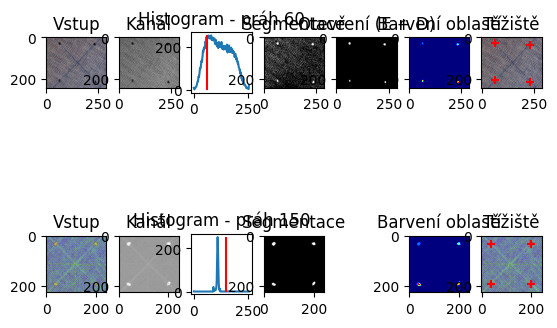

In [2]:
from pathlib import Path
from collections import deque
from tabulate import tabulate

import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_histogram(image, smoothing):
    """Funkce pro získání histogramu

    Args:
        image: Zdrojový obrázek
        smoothing: Síla vyhlazování výsledného histogramu

    Returns:
        Vyhlazený histogram
    """
    histogram = cv2.calcHist([image], [0], None, [256], [0, 256])
    normalized = histogram / np.max(histogram) * 255

    flattened = np.ndarray.flatten(normalized)
    smoothed = np.convolve(flattened, np.ones(smoothing)/smoothing, mode='same')

    return smoothed

def get_centers_of_mass(image):
    """Funkce pro výpočet těžiště v segmentovaných oblastech

    Args:
        image: Matice s očíslovanými oblastmi. Pozadí je označeno číslem 0.

    Returns:
        Pole bodů těžišť.
    """
    points = []

    for i in range(1, np.max(image) + 1):
        copy = np.zeros_like(image)
        copy[image == i] = 1

        moments = cv2.moments(copy, True)
        points.append([int(moments["m10"] / moments["m00"]), int(moments["m01"] / moments["m00"])])

    return points

def bfs_coloring(image):
    """Funkce pro barvení oblastí pomocí prohledávání do šířky

    Args:
        image: Binární obrázek k barvení

    Returns:
        Matice s očíslovanými oblastmi
    """
    rows, cols = image.shape
    visited = np.zeros_like(image).astype("bool")
    colors = np.zeros_like(image).astype("uint8")

    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]

    def is_valid(x, y):
        return 0 <= x < rows and 0 <= y < cols

    def bfs(x, y, color):
        queue = deque([(x, y)])
        visited[x][y] = True
        colors[x][y] = color

        # Zkoumáme všechny okolní body, dokud je v rámci obrázku, nebyli jsme na něm a je vysegmentovaný jako 1
        while queue:
            current_x, current_y = queue.popleft()

            for dx, dy in directions:
                new_x, new_y = current_x + dx, current_y + dy
                if is_valid(new_x, new_y) and not visited[new_x][new_y] and image[new_x][new_y] == 1:
                    queue.append((new_x, new_y))
                    visited[new_x][new_y] = True
                    colors[new_x][new_y] = color

    color_count = 0
    for i in range(rows):
        for j in range(cols):
            if not visited[i][j] and image[i][j] == 1:
                color_count += 1
                bfs(i, j, color_count)

    return colors

def process_image(path, channel, threshold, kernel_size, row):
    image = cv2.imread(Path(path).as_posix())
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    channel_data = image[:, :, channel]
    histogram = get_histogram(channel_data, 2)

    segmented = channel_data.copy()
    segmented[segmented <= threshold] = 1
    segmented[segmented > threshold] = 0

    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    opened = segmented.copy()
    opened = cv2.erode(opened, kernel)
    opened = cv2.dilate(opened, kernel)

    regions = bfs_coloring(opened)
    points = get_centers_of_mass(regions)

    print(tabulate([
        ["Obrazek", path],
        ["Nalezenych oblasti", np.max(regions)],
        ["Teziste", points]
    ]), "\n")

    plt.subplot(rows, cols, (cols * row) + 1)
    plt.imshow(image)
    plt.title("Vstup")

    plt.subplot(rows, cols, (cols * row) + 2)
    plt.imshow(channel_data, cmap="gray")
    plt.title("Kanál")

    plt.subplot(rows, cols, (cols * row) + 3)
    plt.plot(histogram)
    plt.xlim(0, 255)
    plt.ylim(0, 255)
    plt.vlines([threshold], 0, 255, "red")
    plt.axis('square')
    plt.title(f"Histogram - práh {threshold}")

    plt.subplot(rows, cols, (cols * row) + 4)
    plt.title("Segmentace")
    plt.imshow(segmented, cmap="gray")

    plt.subplot(rows, cols, (cols * row) + 5)
    plt.title("Otevření (E + D)")
    plt.imshow(opened, cmap="gray")

    plt.subplot(rows, cols, (cols * row) + 6)
    plt.title("Barvení oblastí")
    plt.imshow(regions / np.max(regions) * 255, cmap='jet')

    plt.subplot(rows, cols, (cols * row) + 7)
    plt.title("Těžiště")
    plt.imshow(image)
    plt.scatter(*zip(*points), marker="+", color="red")

def process_image_2(path, channel, threshold, kernel_size, row):
    image = cv2.imread(Path(path).as_posix())
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    channel_data = image[:, :, 0]
    histogram = get_histogram(channel_data, 2)

    segmented = channel_data.copy()
    segmented[segmented <= threshold] = 0
    segmented[segmented > threshold] = 1

    regions = bfs_coloring(segmented)
    points = get_centers_of_mass(regions)

    print(tabulate([
        ["Obrazek", path],
        ["Nalezenych oblasti", np.max(regions)],
        ["Teziste", points]
    ]), "\n")

    plt.subplot(rows, cols, (cols * row) + 1)
    plt.imshow(image)
    plt.title("Vstup")

    plt.subplot(rows, cols, (cols * row) + 2)
    plt.imshow(channel_data, cmap="gray")
    plt.title("Kanál")

    plt.subplot(rows, cols, (cols * row) + 3)
    plt.plot(histogram)
    plt.xlim(0, 255)
    plt.ylim(0, 255)
    plt.vlines([threshold], 0, 255, "red")
    plt.axis('square')
    plt.title(f"Histogram - práh {threshold}")

    plt.subplot(rows, cols, (cols * row) + 4)
    plt.title("Segmentace")
    plt.imshow(segmented, cmap="gray")

    # plt.subplot(rows, cols, (cols * row) + 5)
    # plt.title("Otevření (E + D)")
    # plt.imshow(opened, cmap="gray")

    plt.subplot(rows, cols, (cols * row) + 6)
    plt.title("Barvení oblastí")
    plt.imshow(regions / np.max(regions) * 255, cmap='jet')

    plt.subplot(rows, cols, (cols * row) + 7)
    plt.title("Těžiště")
    plt.imshow(image)
    plt.scatter(*zip(*points), marker="+", color="red")

rows = 2
cols = 7

process_image("./cv08_im1.bmp", 2, 60, 5, 0)
process_image_2("./cv08_im2.bmp", 0, 150, 3, 1)

plt.show()